In [1]:
!pip install tld

     ------------------------------------ 263.8/263.8 kB 369.1 kB/s eta 0:00:00


In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

from colorama import Fore  #Colorama is a module to color the python outputs

from urllib.parse import urlparse
# This module defines a standard interface to break Uniform Resource Locator (URL) 
# strings up in components (addressing scheme, network location, path etc.), 
# to combine the components back into a URL string, 
# and to convert a “relative URL” to an absolute URL given a “base URL.”

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

### from colorama import Fore

###### Purpose: Adds colors to terminal outputs. For example, you can make success messages green, warnings yellow, or errors red.


### from urllib.parse import urlparse

###### Purpose: Breaks a URL into components like:
             Scheme (http, https)
             Domain (example.com)
             Path (/page1)
###### Can also combine parts back into a full URL or convert relative URLs into absolute ones.


##### KNeighborsClassifier: A classification algorithm based on the nearest neighbors.
##### SGDClassifier: Implements stochastic gradient descent for linear classifiers.
##### GaussianNB: A Naive Bayes model assuming Gaussian distribution for the features.


### from tld import get_tld, is_tld
###### Purpose: Extracts and verifies top-level domains (TLDs) from URLs. For example:
Input: "http://example.com/page1"
Output: "com" (TLD)

In [3]:
data = pd.read_csv('D:/created websites/Spam Mail Prediction/phising url detect/malicious_phish.csv')
data2=data.copy()

In [4]:
data2.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


#### clean the dataset

In [5]:
# deleting the defacements
indexNames = data2[ data2['type'] == 'defacement' ].index
# Delete these row indexes from dataFrame
data2.drop(indexNames , inplace=True)

# deleting the malwares
indexNames = data2[ data2['type'] == 'malware' ].index
# Delete these row indexes from dataFrame
data2.drop(indexNames , inplace=True)

Explanation
Identifying Rows to Delete:

python
Copy code
indexNames = data2[data2['type'] == 'defacement'].index
data2['type'] == 'defacement': Filters rows where the value in the type column is "defacement".
.index: Retrieves the index of these rows.
Deleting the Rows:

python
Copy code
data2.drop(indexNames, inplace=True)
drop(indexNames): Deletes rows with the specified indices.
inplace=True: Ensures the changes are directly applied to the original DataFrame, data2, without creating a copy.
Repeating for Malware:

The same logic is applied for rows where the type column has the value "malware".

#### Feature Extraction

In [6]:
data2['url'] = data2['url'].replace('www.', '', regex=True)
rem = {"Category": {"benign": 0,  "phishing":1}}
data2['Category'] = data2['type']
data2 = data2.replace(rem)
data2.head(20)

,url,type,Category
0,br-icloud.com.br,phishing,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,0
12,myspace.com/video/vid/30602581,benign,0
16,quickfacts.census.gov/qfd/maps/iowa_map.html,benign,0


It modifies the url column to remove any occurrences of "www." from the URLs. This is done using the replace method with the regex=True parameter, enabling pattern-based replacements.

A dictionary named rem is created to map the "Category" values: "benign" is converted to 0, and "phishing" to 1.

The Category column is then created (or replaced) by copying the values from the type column.

Finally, the DataFrame is updated by applying the mappings in the rem dictionary. This means that the values in the Category column are replaced with the corresponding numerical values (0 or 1).

In [7]:
data2['url_len'] = data2['url'].apply(lambda x: len(str(x)))

This line of code adds a new column named url_len to the DataFrame data2. The url_len column contains the length of each URL in the url column.

In [8]:
def process_tld(url):
    try:
#         Extract the top level domain (TLD) 
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

data2['domain'] = data2['url'].apply(lambda i: process_tld(i))

The code extracts the main domain (like example.com) from the URLs in the url column of the data2 DataFrame and saves it in a new column called domain. If a URL is invalid, the domain will be set to None.

In [9]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data2[a] = data2['url'].apply(lambda i: i.count(a))

This code checks how many times certain special characters ('@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//') appear in each URL from the url column of the data2 DataFrame. For each special character, it creates a new column named after that character and stores the count for each URL.

For example:

If a URL contains three @ symbols, the value in the @ column for that URL will be 3.
This process is repeated for all listed special characters.

In [10]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
   ## print(hostname)
    hostname = str(hostname)
   # print(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

data2['abnormal_url'] = data2['url'].apply(lambda i: abnormal_url(i))

In [12]:
def httpSecure(url):
    htp = urlparse(url).scheme #It supports the following URL schemes: file , ftp , gopher , hdl , 
                               #http , https ... from urllib.parse
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
data2['https'] = data2['url'].apply(lambda i: httpSecure(i))

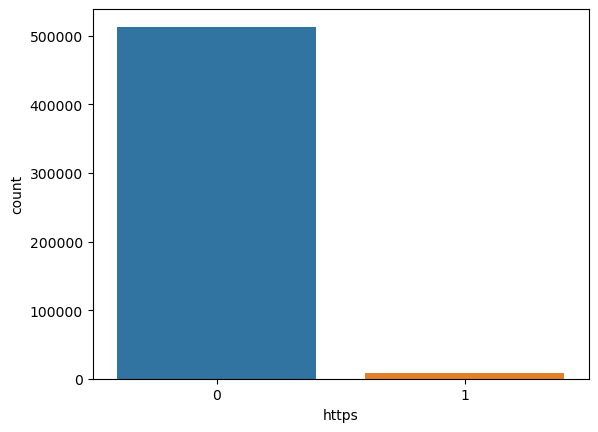

In [13]:
sns.countplot(x='https', data=data2);

In [14]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
data2['digits']= data2['url'].apply(lambda i: digit_count(i))

In [15]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [16]:
data2['letters']= data2['url'].apply(lambda i: letter_count(i))

In [17]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
data2['Shortining_Service'] = data2['url'].apply(lambda x: Shortining_Service(x))

In [18]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
data2['having_ip_address'] = data2['url'].apply(lambda i: having_ip_address(i))

In [19]:
X = data2.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data2['Category']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  91.20%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85626
           1       0.85      0.62      0.72     18817

    accuracy                           0.91    104443
   macro avg       0.89      0.80      0.83    104443
weighted avg       0.91      0.91      0.91    104443

             Confusion_matrix 


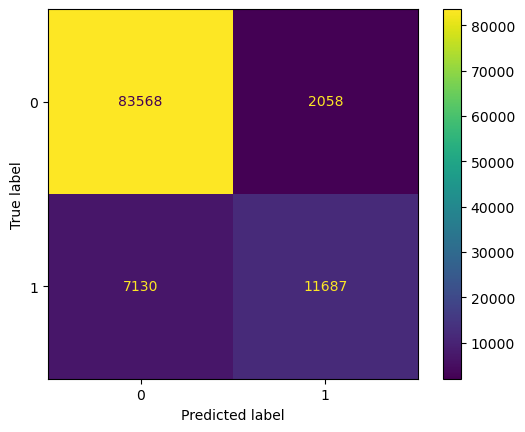

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  91.64%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85626
           1       0.88      0.62      0.73     18817

    accuracy                           0.92    104443
   macro avg       0.90      0.80      0.84    104443
weighted avg       0.91      0.92      0.91    104443

             Confusion_matrix 


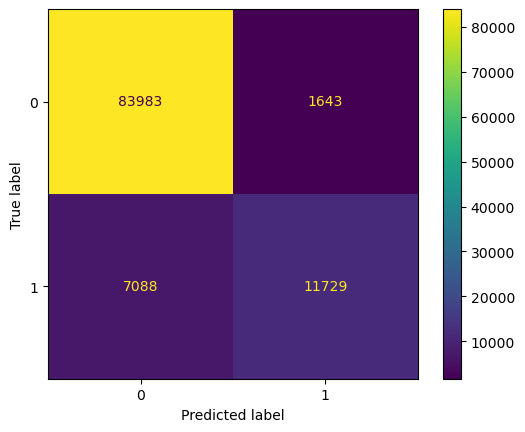

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  85.10%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     85626
           1       0.96      0.18      0.30     18817

    accuracy                           0.85    104443
   macro avg       0.90      0.59      0.61    104443
weighted avg       0.87      0.85      0.81    104443

             Confusion_matrix 


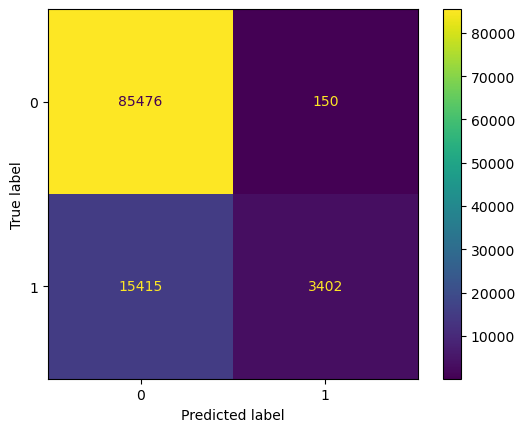

###################- End -###################


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined
models = [DecisionTreeClassifier, RandomForestClassifier, SGDClassifier]
accuracy_test = []

for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc * 100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')

    # Display confusion matrix
    cf_matrix = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
    disp.plot(cmap="viridis")
    plt.show()

    print('\033[31m###################- End -###################\033[0m')


In [23]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'KNeighbors Classifier'],
                      "Accuracy":accuracy_test})

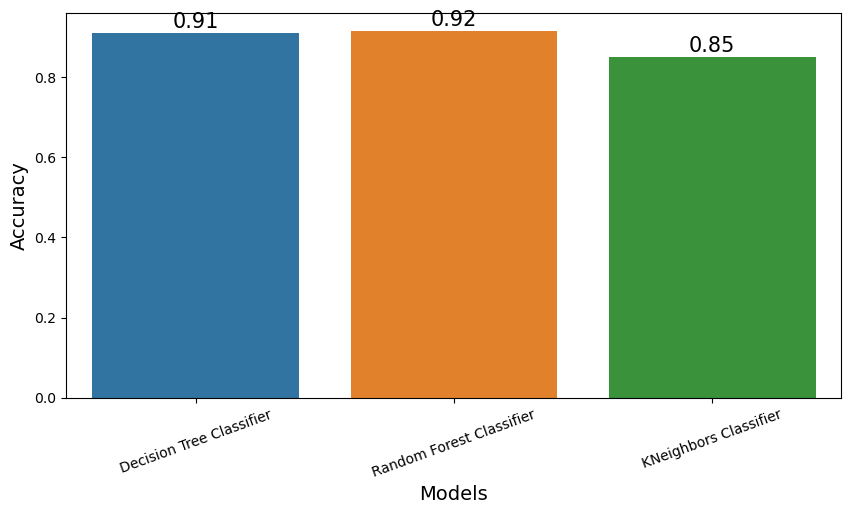

In [24]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

In [25]:
def URL_Converter(urls):
    data= pd.DataFrame()
    data['url'] = pd.Series(urls)

    
    data['url_len'] = data['url'].apply(lambda x: len(str(x)))
    data['domain'] = data['url'].apply(lambda i: process_tld(i))
    feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
    for a in feature:
        data[a] = data['url'].apply(lambda i: i.count(a))  
    data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
    data['https'] = data['url'].apply(lambda i: httpSecure(i))
    data['digits']= data['url'].apply(lambda i: digit_count(i))
    data['letters']= data['url'].apply(lambda i: letter_count(i))
    data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))
    data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))
    print(data.columns)
    X = data.drop(['url','domain'],axis=1)
    
    return X

In [26]:
urls=['https://logistilink.xyz',
      'https://iridescent-croquembouche-4b8508.netlify.app/',
      'apple-search.info',
      'www.itcarezone.com/xlrmp/files/anna.exe',
      'https://towardsdatascience.com/',
      'https://medium.com/'
     ]
test_data=URL_Converter(urls)
models = [DecisionTreeClassifier,RandomForestClassifier,SGDClassifier]

for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(test_data)
    print(pred)

Index(['url', 'url_len', 'domain', '@', '?', '-', '=', '.', '#', '%', '+', '$',
       '!', '*', ',', '//', 'abnormal_url', 'https', 'digits', 'letters',
       'Shortining_Service', 'having_ip_address'],
      dtype='object')
#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
[1 1 1 1 1 1]
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
[1 1 1 1 1 1]
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
[1 1 0 0 1 1]


In [27]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'SGDClassifier'],
                      "Accuracy":accuracy_test})
print(output)

                      Model  Accuracy
0  Decision Tree Classifier  0.912029
1  Random Forest Classifier  0.916404
2             SGDClassifier  0.850971
